In [1]:
#-*- coding: utf-8 -*-

import tensorflow as tf
# dont display much info of tensorflow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # or any level you prefer

# limit gpu memory usage only as much as needed
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
        print("Setting memory growth to True for GPU: ", gpu)
        tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print("Physical GPUs: ", len(gpus), "Logical GPUs: ", len(logical_gpus))
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.layers import Lambda, Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, GlobalAveragePooling2D, Concatenate, Add, AveragePooling2D
import numpy as np

import matplotlib.pyplot as plt


2024-01-21 18:29:31.889983: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-01-21 18:29:31.982123: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-21 18:29:31.982184: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-21 18:29:31.986392: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-21 18:29:32.004848: I tensorflow/core/platform/cpu_feature_guar

Setting memory growth to True for GPU:  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
Physical GPUs:  1 Logical GPUs:  1


In [2]:
# Load data
manta_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_manta.npy"
xiris_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_xiris.npy"
y_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_y.npy"
feats_path = "/home/vm/SSL_Project_1/data/processed/bag_2023-07-04_15-23-48/_feats.npy"

# load numpy arrays and display shapes
manta = np.load(manta_path)
xiris = np.load(xiris_path)
params = np.load(y_path)
print("manta shape: ", manta.shape)
print("xiris shape: ", xiris.shape)
feats = np.load(feats_path)
print("feats shape: ", feats.shape)



# use laser power and velocity as labels
params = params[:, :2]
print("y shape: ", params.shape)

#y = np.concatenate((params, feats[:, 1:3]), axis=1) # L, H
#print("y shape: ", y.shape)

params_max = np.max(params, axis=0)
y = params / params_max

# print max of each column
print("max of each column: ", params_max)

feats = feats[:, 1:3] # remove laser power and velocity

feats_max = np.max(feats, axis=0)
feats = feats / feats_max

print("feats max: ", feats_max)


manta shape:  (9587, 320, 320)
xiris shape:  (9587, 320, 320)
feats shape:  (9587, 8)
y shape:  (9587, 2)
max of each column:  [2750   15]
feats max:  [232. 159.]


In [3]:
# divide data into train and test sets
train_split = 0.8
# randomize data with seed
np.random.seed(42)
indices = np.arange(len(y))

# shuffle indices
np.random.shuffle(indices)

manta = manta[indices]
xiris = xiris[indices]
y = y[indices]
feats = feats[indices]

# split data
train_samples = int(train_split * len(y))
train_manta = manta[:train_samples]
train_xiris = xiris[:train_samples]
train_y = y[:train_samples]
train_feats = feats[:train_samples]

test_manta = manta[train_samples:]
test_xiris = xiris[train_samples:]
test_y = y[train_samples:]
test_feats = feats[train_samples:]

In [4]:
# create a function to encode y
def encode_one_column(y):
    # create a new array of zeros with the same shape as y
    encoded_y = np.zeros(y.shape)
    # get the unique values in y
    unique_values = np.unique(y)
    # loop through the unique values
    for i, value in enumerate(unique_values):
        # find the indices where y equals the unique value
        indices = np.where(y == value)
        # set the indices in encoded_y to i
        encoded_y[indices] = i
    return encoded_y

# create new array to store encoded y
encoded_y = np.zeros(y.shape)
# loop through each column in y and encode it
for i in range(y.shape[1]):
    encoded_y[:, i] = encode_one_column(y[:, i])
    
# convert to int
encoded_y = encoded_y.astype(int) 

In [5]:
train_encoded_y = encoded_y[:train_samples]

In [6]:

# crate pairs
def create_pairs_2_labels(manta, xiris, y_encoded, feats):
    # set seed
    np.random.seed(42)
        
    pairs = []
    labels = []
    features = []
    
    # define numclasses with the same columns as y_encoded
    numclasses = np.zeros(y_encoded.shape[1], dtype=int)

    for i in range(y_encoded.shape[1]):
        unique_values, unique_indices = np.unique(y_encoded[:, i], return_inverse=True)
        numclasses[i] = len(unique_values)
    
    # creade idx1 and idx2
    idx1 = [np.where(y_encoded==i)[0] for i in range(numclasses[0])]
    idx2  = [np.where(y_encoded==i)[0] for i in range(numclasses[1])]

    for idxA in range(len(y_encoded)):
        # grab the current image and label belonging to the current iteration
        currentImage = manta[idxA]
        label = y_encoded[idxA]
        p1 = label[0]
        v1 = label[1]
        p2 = np.random.choice(np.delete(np.arange(numclasses[0]), p1))
        v2 = np.random.choice(np.delete(np.arange(numclasses[1]), v1))

        # randomly pick an image that belongs to the same class label
        idxB = np.random.choice(np.intersect1d(idx1[p1], idx2[v1])) #np.random.choice(idx[p1][v1])
        x11 = xiris[idxB]
        # prepare a positive pair and update the images and labels lists, respectively
        pairs.append([currentImage, x11])
        labels.append([p1, v1, p1, v1])
        features.append([feats[idxA][0], feats[idxA][1], feats[idxB][0], feats[idxB][1]])

        idxC = np.random.choice(np.intersect1d(idx1[p2], idx2[v1]))
        x21 = xiris[idxC]
        pairs.append([currentImage, x21])
        labels.append([p1, v1, p2, v1])
        features.append([feats[idxA][0], feats[idxA][1], feats[idxC][0], feats[idxC][1]])   
            
        idxD = np.random.choice(np.intersect1d(idx1[p1], idx2[v2]))
        x12 = xiris[idxD]
        pairs.append([currentImage, x12])
        labels.append([p1, v1, p1, v2])
        features.append([feats[idxA][0], feats[idxA][1], feats[idxD][0], feats[idxD][1]])
        
        idxE = np.random.choice(np.intersect1d(idx1[p2], idx2[v2]))
        x22 = xiris[idxE]
        pairs.append([currentImage, x22])
        labels.append([p1, v1, p2, v2])
        features.append([feats[idxA][0], feats[idxA][1], feats[idxE][0], feats[idxE][1]])
    

        if idxA % 1000 == 0:
            print(f"Creating pairs for image {idxA}/{len(y_encoded)}, Completed {int(idxA/len(y_encoded)*100)}%")
    
    return np.array(pairs), np.array(labels), np.array(features)

                                                                                             
# create pairs
pairs, labels, features = create_pairs_2_labels(train_manta, train_xiris, train_encoded_y, train_feats)
print("pairs shape: ", pairs.shape)
print("labels shape: ", labels.shape)

Creating pairs for image 0/7669, Completed 0%
Creating pairs for image 1000/7669, Completed 13%
Creating pairs for image 2000/7669, Completed 26%
Creating pairs for image 3000/7669, Completed 39%
Creating pairs for image 4000/7669, Completed 52%
Creating pairs for image 5000/7669, Completed 65%
Creating pairs for image 6000/7669, Completed 78%
Creating pairs for image 7000/7669, Completed 91%
pairs shape:  (30676, 2, 320, 320)
labels shape:  (30676, 4)


In [7]:
""" from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, shuffle=True)

del pairs, labels

# print shapes
print("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)
print("X_test shape: ", X_test.shape, "y_test shape: ", y_test.shape) """

' from sklearn.model_selection import train_test_split\n\nX_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42, shuffle=True)\n\ndel pairs, labels\n\n# print shapes\nprint("X_train shape: ", X_train.shape, "y_train shape: ", y_train.shape)\nprint("X_test shape: ", X_test.shape, "y_test shape: ", y_test.shape) '

In [8]:
def create_encoder(input_shape=(320, 320, 1)):
    inputs = Input(shape=input_shape)
    
    x = Conv2D(16, (3, 3), activation='relu')(inputs)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(32, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)
    
    x = Conv2D(64, (3, 3), activation='relu')(x)
    x = MaxPooling2D((2, 2))(x)

    x = Flatten()(x)
    
    #x = Dense(128, activation='relu')(x)
    model = Model(inputs=inputs, outputs=x)
    return model

# add projection head
def add_projection_head(input_shape, encoder, embedding_dim):
    inputs = Input(shape=input_shape)
    features = encoder(inputs)
    #features = Dense(128, activation='relu')(features)
    model = Model(inputs=inputs, outputs=features)  
    return model

input_shape = (320, 320, 1)
embedding_dim= 128
batch_size = 64
epochs = 40
validation_split = 0.2
learning_rate = 0.0001

encoder = create_encoder(input_shape)
encoder_with_projection_head = add_projection_head(input_shape, encoder, embedding_dim)

manta = Input(shape=input_shape)
xiris = Input(shape=input_shape)

manta_encoded = encoder_with_projection_head(manta)
xiris_encoded = encoder_with_projection_head(xiris)

manta_outputs_p = Dense(embedding_dim, activation='relu')(manta_encoded)
manta_outputs_v = Dense(embedding_dim, activation='relu')(manta_encoded)

xiris_outputs_p = Dense(embedding_dim, activation='relu')(xiris_encoded)
xiris_outputs_v = Dense(embedding_dim, activation='relu')(xiris_encoded)

reg_manta_p = tf.keras.layers.Dense(1, activation="linear")(manta_outputs_p) 
reg_manta_v = tf.keras.layers.Dense(1, activation="linear")(manta_outputs_v) 

reg_xiris_p = tf.keras.layers.Dense(1, activation="linear")(xiris_outputs_p) 
reg_xiris_v = tf.keras.layers.Dense(1, activation="linear")(xiris_outputs_v) 

siamese_net = tf.keras.Model(inputs=[manta, xiris], outputs=[manta_outputs_p, manta_outputs_v, xiris_outputs_p, xiris_outputs_v, reg_manta_p, reg_manta_v, reg_xiris_p, reg_xiris_v])

siamese_net.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 92416)                23296     ['input_3[0][0]',             
                                                                     'input_4[0][0]']             
                                                                                                  
 dense (Dense)               (None, 128)                  1182937   ['model_1[0][0]']       

In [9]:
class SiameseModel(Model):
    """
        The Siamese Network model with a custom training and testing loops.
        Computes the contrastive loss using the two embeddings produced by the Siamese Network.
    """
    def __init__(self, siamese_network):
        super().__init__()
        self.siamese_network = siamese_network
        self.margin = 1.0
        self.loss_tracker = tf.keras.metrics.Mean(name="loss")


    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # Unpack the data
        X, y = data  
        #print(y)
        
        with tf.GradientTape() as tape:
            y_pred = self.siamese_network(X) # Forward pass
            #print(y_pred)
            # compute loss
            loss = self.contrastive_loss_PV(y_true=y, y_pred=y_pred)
            loss_reg_manta_p = tf.keras.losses.MeanSquaredError()(y[:, 0], y_pred[4])
            loss_reg_manta_v = tf.keras.losses.MeanSquaredError()(y[:, 1], y_pred[5])
            loss_reg_xiris_p = tf.keras.losses.MeanSquaredError()(y[:, 2], y_pred[6])
            loss_reg_xiris_v = tf.keras.losses.MeanSquaredError()(y[:, 3], y_pred[7])
            loss = loss + loss_reg_manta_p + loss_reg_manta_v + loss_reg_xiris_p + loss_reg_xiris_v
            
        # Storing the gradients of the loss function with respect to the weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data): # model.evaluate() stores the losses and metrics in a list
        # Unpack the data
        X, y = data
        
        # Compute predictions
        y_pred = self.siamese_network(X, training=False)
        # The loss is computed on the test set
        loss = self.contrastive_loss_PV(y_true=y, y_pred=y_pred)
        loss_reg_manta_p = tf.keras.losses.MeanSquaredError()(y[:, 0], y_pred[4])
        loss_reg_manta_v = tf.keras.losses.MeanSquaredError()(y[:, 1], y_pred[5])
        loss_reg_xiris_p = tf.keras.losses.MeanSquaredError()(y[:, 2], y_pred[6])
        loss_reg_xiris_v = tf.keras.losses.MeanSquaredError()(y[:, 3], y_pred[7])
        loss = loss + loss_reg_manta_p + loss_reg_manta_v + loss_reg_xiris_p + loss_reg_xiris_v
        
        # Update the loss metric
        self.loss_tracker.update_state(loss)
    
        return {"loss": self.loss_tracker.result()}
    

    def contrastive_loss_PV(self, y_true, y_pred):
        # Extract embeddings
        #p1, v1, p2, v2, _ = tf.split(y_pred, num_or_size_splits=[128, 128, 128, 128], axis=1)
        # Extract embeddings
        p1, v1, p2, v2 = y_pred[0], y_pred[1], y_pred[2], y_pred[3]

        # Calculate distances
        distance_p = tf.reduce_sum(tf.square(p1 - p2), axis=1, keepdims=True)
        distance_v = tf.reduce_sum(tf.square(v1 - v2), axis=1, keepdims=True)
        
        # convert to float32
        distance_p = tf.cast(distance_p, dtype=tf.float32)
        distance_v = tf.cast(distance_v, dtype=tf.float32)
        
        # squeeze distance_p and distance_v
        distance_p = tf.squeeze(distance_p, axis=-1)
        distance_v = tf.squeeze(distance_v, axis=-1)

        # Convert y_true to float32
        y_true = tf.cast(y_true, dtype=tf.float32)
        # Ensure margin has the same data type as distance_p and distance_v
        margin = tf.cast(self.margin, dtype=tf.float32)

        # Extract true labels for each task
        y_true_p = tf.cast(tf.not_equal(y_true[:, 0], y_true[:, 2]), tf.float32)
        y_true_v = tf.cast(tf.not_equal(y_true[:, 1], y_true[:, 3]), tf.float32)
        
        square_pred_p = tf.square(distance_p)
        margin_square_p = tf.square(tf.maximum(margin - distance_p, 0))
        loss_p = tf.reduce_mean((1 - y_true_p) * square_pred_p + (y_true_p) * margin_square_p)
        
        square_pred_v = tf.square(distance_v)
        margin_square_v = tf.square(tf.maximum(margin - distance_v, 0))
        loss_v = tf.reduce_mean((1 - y_true_v) * square_pred_v + (y_true_v) * margin_square_v)

        # Combine the losses
        combined_loss = loss_p + loss_v

        return combined_loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [10]:
# create siamese model
siamese_model = SiameseModel(siamese_net)
# compile model
siamese_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
# fit model
siamese_model.fit(
    x=[pairs[:, 0], pairs[:, 1]], 
    y=labels,
    batch_size=batch_size, 
    epochs=epochs,
    validation_split=validation_split,
)

Epoch 1/40


2024-01-21 18:31:22.374227: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
2024-01-21 18:31:22.720375: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 18:31:24.101819: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-01-21 18:31:25.050542: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f42d5434920 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-01-21 18:31:25.050641: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA RTX A6000, Compute Capability 8.6
2024-01-21 18:31:25.091521: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1705861885.339374 1985437 device_compiler.h:186] 

384/384 [==============================] - 54s 115ms/step - loss: 2.7940 - val_loss: 2.2982
Epoch 2/40
384/384 [==============================] - 33s 85ms/step - loss: 2.0804 - val_loss: 1.8923
Epoch 3/40
384/384 [==============================] - 32s 84ms/step - loss: 1.7719 - val_loss: 1.6563
Epoch 4/40
384/384 [==============================] - 31s 82ms/step - loss: 1.5829 - val_loss: 1.5191
Epoch 5/40
384/384 [==============================] - 31s 81ms/step - loss: 1.4644 - val_loss: 1.4546
Epoch 6/40
384/384 [==============================] - 31s 80ms/step - loss: 1.3925 - val_loss: 1.3731
Epoch 7/40
384/384 [==============================] - 30s 79ms/step - loss: 1.3316 - val_loss: 1.3467
Epoch 8/40
384/384 [==============================] - 30s 79ms/step - loss: 1.2921 - val_loss: 1.3174
Epoch 9/40
384/384 [==============================] - 31s 80ms/step - loss: 1.2580 - val_loss: 1.3103
Epoch 10/40
384/384 [==============================] - 30s 79ms/step - loss: 1.2289 - val_lo

In [11]:
""" # plot history
plt.plot(siamese_model.history.history['loss'], label='train loss')
plt.plot(siamese_model.history.history['val_loss'], label='val loss')
plt.legend()
plt.show() """

" # plot history\nplt.plot(siamese_model.history.history['loss'], label='train loss')\nplt.plot(siamese_model.history.history['val_loss'], label='val loss')\nplt.legend()\nplt.show() "

In [12]:
for i, layer in enumerate(siamese_model.siamese_network.layers):
    print(i, layer.name)

0 input_3
1 input_4
2 model_1
3 dense
4 dense_1
5 dense_2
6 dense_3
7 dense_4
8 dense_5
9 dense_6
10 dense_7


In [13]:
siamese_model.siamese_network.inputs[0]

<KerasTensor: shape=(None, 320, 320, 1) dtype=float32 (created by layer 'input_3')>

In [14]:
inputs = Input(shape=(320, 320, 1))

new_model = tf.keras.Model(inputs=siamese_model.siamese_network.inputs[0], outputs=[siamese_model.siamese_network.layers[3].output, siamese_model.siamese_network.layers[4].output])
new_model.summary()

# set weights of new model 
for layer in new_model.layers:
    layer.set_weights(siamese_model.siamese_network.get_layer(layer.name).get_weights())
    print(layer.name, "weights set")
    layer.trainable = False
    

x = new_model(inputs)
# merge the last 2 layers in a single layer
x = layers.concatenate(x)
# add a two regression heads
#x = Dense(128, activation='relu')(x)
output_l = Dense(1, activation="linear", name="lenght")(x)
output_h = Dense(1, activation="linear", name="height")(x)

model_3 = Model(inputs=inputs, outputs=[output_l, output_h])
model_3.summary()           

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 320, 320, 1)]        0         []                            
                                                                                                  
 model_1 (Functional)        (None, 92416)                23296     ['input_3[0][0]']             
                                                                                                  
 dense (Dense)               (None, 128)                  1182937   ['model_1[0][0]']             
                                                          6                                       
                                                                                                  
 dense_1 (Dense)             (None, 128)                  1182937   ['model_1[0][0]']       

In [15]:
X_train = np.concatenate((train_manta, train_xiris), axis=0)

X_train.shape
del train_manta, train_xiris, train_y, train_encoded_y, pairs, labels, features


y_train = np.concatenate((train_feats, train_feats), axis=0)
y_train.shape

del train_feats

In [16]:
# fit model
learning_rate = 0.0001
model_3.compile(optimizer=tf.keras.optimizers.Adam(learning_rate), loss='mse')

batch_size = 64
epochs = 50

history = model_3.fit(x=X_train,
            y=[y_train[:, 0], y_train[:, 1]],
            #y=y_train[:, 2:], # L, H
            batch_size=batch_size, epochs=epochs, validation_split=0.2)


Epoch 1/50
192/192 [==============================] - 12s 56ms/step - loss: 0.3695 - lenght_loss: 0.3185 - height_loss: 0.0510 - val_loss: 0.3478 - val_lenght_loss: 0.2874 - val_height_loss: 0.0603
Epoch 2/50
192/192 [==============================] - 6s 31ms/step - loss: 0.2256 - lenght_loss: 0.1978 - height_loss: 0.0278 - val_loss: 0.2432 - val_lenght_loss: 0.2026 - val_height_loss: 0.0406
Epoch 3/50
192/192 [==============================] - 6s 31ms/step - loss: 0.1484 - lenght_loss: 0.1254 - height_loss: 0.0231 - val_loss: 0.1849 - val_lenght_loss: 0.1506 - val_height_loss: 0.0344
Epoch 4/50
192/192 [==============================] - 6s 31ms/step - loss: 0.1069 - lenght_loss: 0.0854 - height_loss: 0.0214 - val_loss: 0.1520 - val_lenght_loss: 0.1203 - val_height_loss: 0.0317
Epoch 5/50
192/192 [==============================] - 6s 32ms/step - loss: 0.0851 - lenght_loss: 0.0651 - height_loss: 0.0200 - val_loss: 0.1331 - val_lenght_loss: 0.1035 - val_height_loss: 0.0296
Epoch 6/50
192

In [17]:
del X_train, y_train

In [18]:
X_test = np.concatenate((test_manta, test_xiris), axis=0)
y_test = np.concatenate((test_feats, test_feats), axis=0)

del  test_xiris, test_y#, test_feats #test_manta,

In [19]:
score = model_3.evaluate(X_test, [y_test[:, 0], y_test[:, 1]], verbose=0)
print(score)

[0.02557404153048992, 0.021319232881069183, 0.004254810977727175]


120/120 [==============================] - 1s 11ms/step
r2 score:  0.6078463284535157 0.6359997190461097


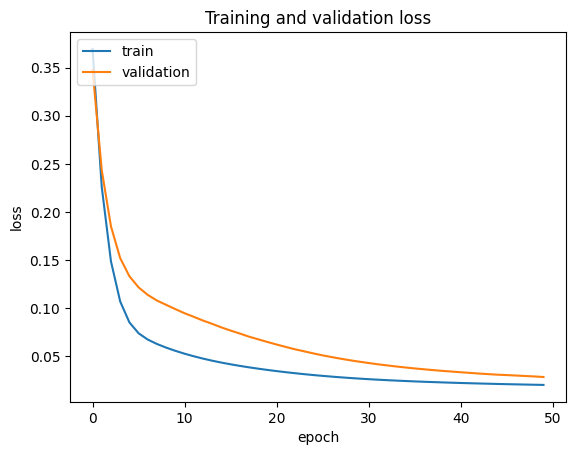

In [20]:
# eval regression model
from sklearn.metrics import r2_score

y_pred_l, y_pred_h = model_3.predict(X_test)
r2_l = r2_score(y_test[:,0], y_pred_l)
r2_h = r2_score(y_test[:,1], y_pred_h)
print("r2 score: ", r2_l, r2_h)

# plot loss and metrics: mse and mae
import matplotlib.pyplot as plt

# plot loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')

plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


In [21]:
X_test_new = test_manta
del test_manta

y_test_new = test_feats 
del test_feats

In [22]:
y_pred_l_new, y_pred_h_new = model_3.predict(X_test_new)

60/60 [==============================] - 1s 13ms/step


In [23]:
r2_l_new = r2_score(y_test_new[:,0], y_pred_l_new)
r2_h_new = r2_score(y_test_new[:,1], y_pred_h_new)


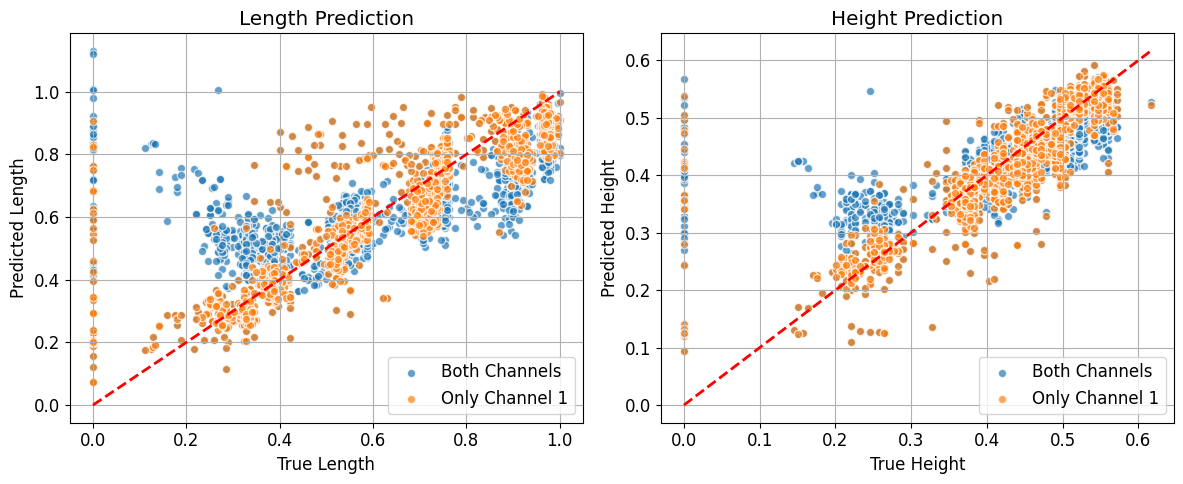

In [24]:
import matplotlib.pyplot as plt

# Increase overall text size
plt.rcParams.update({'font.size': 12})

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plotting the first scatter plot (length prediction)
axs[0].scatter(y_test[:, 0], y_pred_l, alpha=0.7, edgecolors='w', label='Both Channels')
axs[0].scatter(y_test_new[:, 0], y_pred_l_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[0].plot([min(y_test[:, 0]), max(y_test[:, 0])], [min(y_test[:, 0]), max(y_test[:, 0])], '--', color='red', linewidth=2)
axs[0].set_title("Length Prediction")
axs[0].set_xlabel("True Length")
axs[0].set_ylabel("Predicted Length")
axs[0].legend()
axs[0].grid(True)

# Plotting the second scatter plot (height prediction)
axs[1].scatter(y_test[:, 1], y_pred_h, alpha=0.7, edgecolors='w', label='Both Channels')
axs[1].scatter(y_test_new[:, 1], y_pred_h_new, alpha=0.7, edgecolors='w', label='Only Channel 1')
axs[1].plot([min(y_test[:, 1]), max(y_test[:, 1])], [min(y_test[:, 1]), max(y_test[:, 1])], '--', color='red', linewidth=2)
axs[1].set_title("Height Prediction")
axs[1].set_xlabel("True Height")
axs[1].set_ylabel("Predicted Height")
axs[1].legend()
axs[1].grid(True)

# Adjust layout for better visualization
plt.tight_layout()

# Show the plot
plt.show()

Layer name: concatenate
120/120 [==============================] - 1s 10ms/step


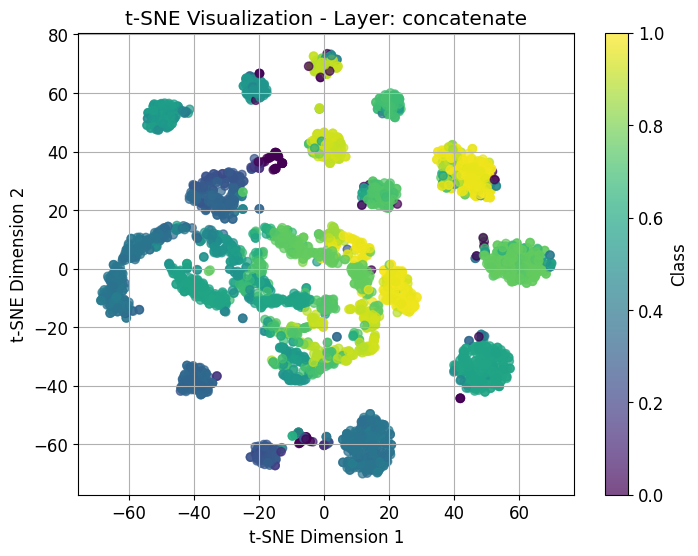

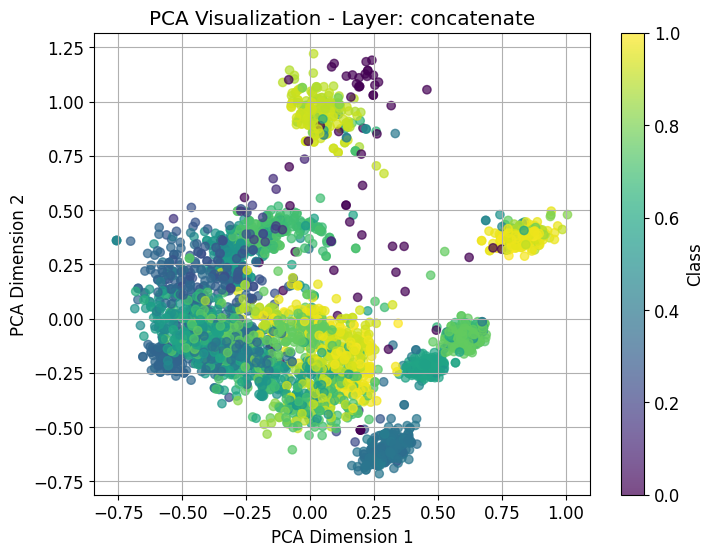

Layer name: concatenate
60/60 [==============================] - 1s 9ms/step


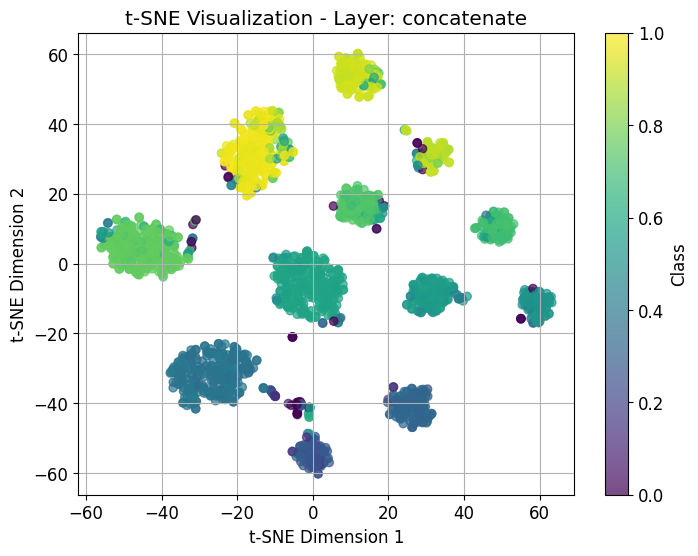

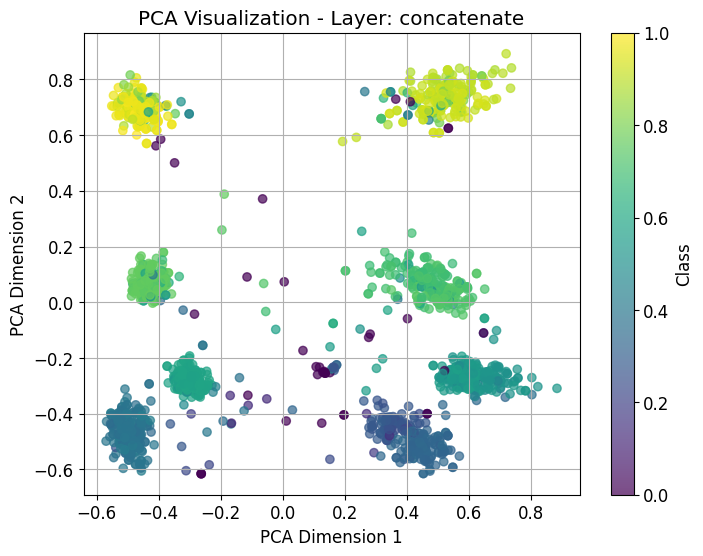

(array([[ 10.151903 ,  49.79168  ],
        [ 61.47082  , -15.003732 ],
        [-17.540926 ,  24.153366 ],
        ...,
        [-50.517757 ,  10.2705965],
        [-23.747885 , -28.201735 ],
        [ -7.5198293,  35.048004 ]], dtype=float32),
 array([[ 0.45343992,  0.6872053 ],
        [ 0.7589074 , -0.2716966 ],
        [-0.4421195 ,  0.6779926 ],
        ...,
        [-0.40357536,  0.04485799],
        [-0.5091524 , -0.48542267],
        [-0.43262744,  0.6832358 ]], dtype=float32))

In [25]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA


N_LAYER = -3

def eval_tsne_pca(model, n_layer, x_test, y_test, plot=True):
    
    # Get intermediate layer output and print the name
    intermediate_layer_model = tf.keras.Model(inputs=model.input, outputs=model.layers[n_layer].output)
    layer_name = model.layers[n_layer].name
    print("Layer name:", layer_name)
    
    intermediate_activations = intermediate_layer_model.predict(x_test)

    # Apply t-SNE
    tsne = TSNE(n_components=2, random_state=42)
    tsne_results = tsne.fit_transform(intermediate_activations)

    # Visualize t-SNE results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_test[:, 0], cmap='viridis', alpha=0.7)
        plt.title(f't-SNE Visualization - Layer: {layer_name}')
        plt.xlabel('t-SNE Dimension 1')
        plt.ylabel('t-SNE Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    # Apply PCA
    pca = PCA(n_components=2)
    pca_results = pca.fit_transform(intermediate_activations)

    # Visualize PCA results
    if plot:
        plt.figure(figsize=(8, 6))
        plt.scatter(pca_results[:, 0], pca_results[:, 1], c=y_test[:, 0], cmap='viridis', alpha=0.7)
        plt.title(f'PCA Visualization - Layer: {layer_name}')
        plt.xlabel('PCA Dimension 1')
        plt.ylabel('PCA Dimension 2')
        plt.colorbar(label='Class')
        plt.grid(True)
        plt.show()

    return tsne_results, pca_results

eval_tsne_pca(model_3, n_layer=N_LAYER, x_test=X_test, y_test=y_test, plot=True)

eval_tsne_pca(model_3, n_layer=N_LAYER, x_test=X_test_new, y_test=y_test_new, plot=True)

# eval for X_test_new
